In [1]:
# just to publish on git
import warnings
warnings.filterwarnings('ignore')

## week0_09 practice: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

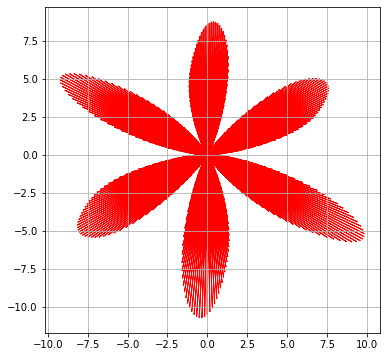

In [3]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta))\
      * (1 + 0.01 * torch.cos(24 * theta))\
      * (0.5 + 0.05) * torch.cos(200 * theta)\
      * (10 + torch.sin(10 * theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = torch.sin(theta) * rho
y = torch.cos(theta) * rho


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [4]:
from torch import nn
from torch.nn import functional as F

In [ ]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/basic_s20/week0_09_Optimization_and_Regularization_in_DL/notmnist.py -nc

In [5]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [6]:
print(X_train.shape)

(14043, 1, 28, 28)


In [7]:
# Note: Dataset - class from PyTorch

class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
full_dataset = DatasetMNIST(
    './notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [9]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [10]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

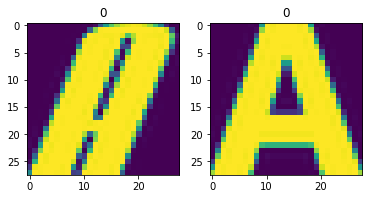

In [11]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [12]:
train_loader = DataLoader(
    full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [13]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [14]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


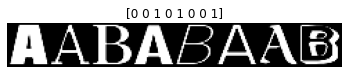

In [15]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [16]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [17]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [18]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


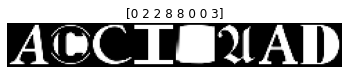

In [19]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [20]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [21]:
a = Flatten()

In [22]:
a(img).shape

torch.Size([784])

In [23]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [24]:
import time

from IPython.display import clear_output

In [25]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [26]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE 
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [27]:
# Note: create new dataset using indexes from subset_ind
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [28]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(
    dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)
 
print(f'training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')
print(f'\nType of train_dataset:\n{type(train_dataset)}')

training size: 2996
validation size: 748

Type of train_dataset:
<class 'torch.utils.data.dataset.Subset'>


In [29]:
batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

In [30]:
for X_, y_ in train_loader: 
    print(X_,'\n'*3, y_)
    break

tensor([[-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9275,  ...,  1.2530,  1.2530,  0.9964],
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        ...,
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9018,  ..., -0.9018, -0.9275, -0.9275]]) 


 tensor([9, 0, 3, 8, 0, 5, 6, 0, 9, 6, 6, 4, 5, 7, 3, 3, 9, 7, 5, 2, 8, 9, 8, 4,
        1, 4, 5, 7, 8, 0, 9, 2])


In [31]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [39]:
# There is no parameters for training 
# Softmax is here 
loss_func = nn.CrossEntropyLoss()

In [33]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    #nn.Sigmoid(),
)
model.to(device, torch.float32)


# Note: opt is responsible for
# 1. computing gradients 
# 2. updates model with lr
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [34]:
from torchsummary import summary

In [35]:
summary(model,(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [36]:
# Note: important to drop grad from tensor
a = torch.ones(1).requires_grad_(True)
b = 2
a = b * a
a.backward()
print(a)
print(a.item())
del a,b

tensor([2.], grad_fn=<MulBackward0>)
2.0


In [37]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior + calc grads
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
             
            opt.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            loss.backward()
            opt.step()            
            # Note: loss.item() - to get value without computation graph
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad(): # do not calculate grads
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item())### YOUR CODE HERE)
                y_pred = predictions.max(1)[1].data### YOUR CODE HERE
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))### YOUR CODE HERE)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [40]:
n_epochs = 30

train_loss,  val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.096s
	  training loss: 0.778080
	validation loss: 0.566515
	validation accuracy: 0.857
Epoch 2 of 30 took 0.086s
	  training loss: 0.454698
	validation loss: 0.511335
	validation accuracy: 0.868
Epoch 3 of 30 took 0.103s
	  training loss: 0.400041
	validation loss: 0.515981
	validation accuracy: 0.867
Epoch 4 of 30 took 0.088s
	  training loss: 0.363046
	validation loss: 0.499025
	validation accuracy: 0.872
Epoch 5 of 30 took 0.080s
	  training loss: 0.337038
	validation loss: 0.499461
	validation accuracy: 0.876
Epoch 6 of 30 took 0.082s
	  training loss: 0.315710
	validation loss: 0.520299
	validation accuracy: 0.864
Epoch 7 of 30 took 0.088s
	  training loss: 0.296371
	validation loss: 0.501304
	validation accuracy: 0.871
Epoch 8 of 30 took 0.091s
	  training loss: 0.278273
	validation loss: 0.498155
	validation accuracy: 0.872
Epoch 9 of 30 took 0.074s
	  training loss: 0.266640
	validation loss: 0.559823
	validation accuracy: 0.856
Epoch 10 of 30 took 0.081s
	

In [41]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

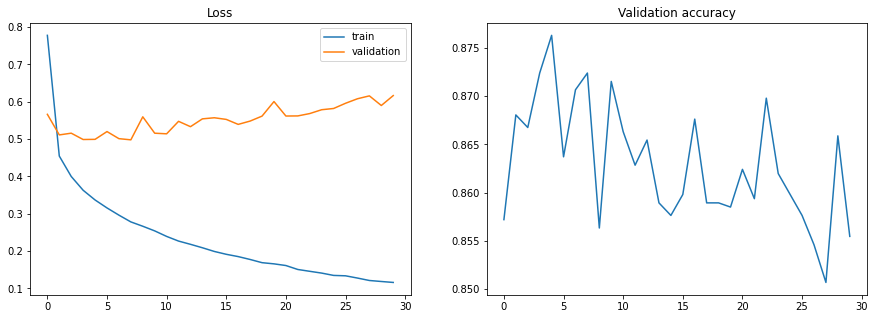

In [42]:
plot_train_process(train_loss, val_loss, val_accuracy)

Overfitting - small dataset and simple model

## Real network

In [43]:
# create network again just in case
# more complex model:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.385s
	  training loss: 0.638203
	validation loss: 0.496729
	validation accuracy: 0.863
Epoch 2 of 30 took 0.361s
	  training loss: 0.326031
	validation loss: 0.409162
	validation accuracy: 0.885
Epoch 3 of 30 took 0.446s
	  training loss: 0.234090
	validation loss: 0.445047
	validation accuracy: 0.882
Epoch 4 of 30 took 0.352s
	  training loss: 0.153445
	validation loss: 0.502570
	validation accuracy: 0.881
Epoch 5 of 30 took 0.378s
	  training loss: 0.110330
	validation loss: 0.508687
	validation accuracy: 0.885
Epoch 6 of 30 took 0.375s
	  training loss: 0.089409
	validation loss: 0.632578
	validation accuracy: 0.868
Epoch 7 of 30 took 0.441s
	  training loss: 0.083023
	validation loss: 0.608635
	validation accuracy: 0.885
Epoch 8 of 30 took 0.414s
	  training loss: 0.050436
	validation loss: 0.657663
	validation accuracy: 0.882
Epoch 9 of 30 took 0.443s
	  training loss: 0.033639
	validation loss: 0.696589
	validation accuracy: 0.885
Epoch 10 of 30 took 0.429s
	

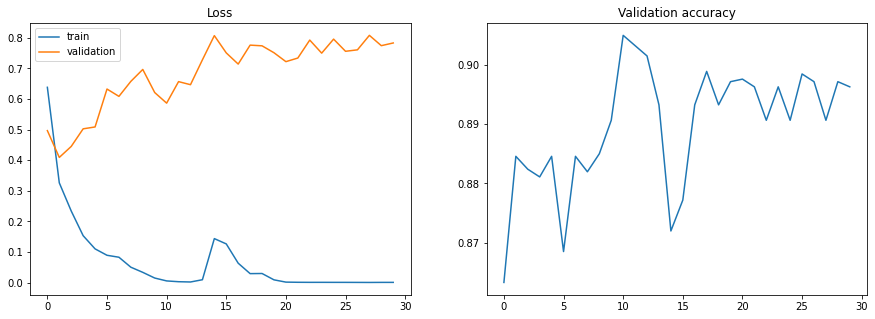

In [45]:
plot_train_process(train_loss, val_loss, val_accuracy)

Better, but we also have overfitting

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [46]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),  
    nn.Dropout(p=0.6),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [47]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.320s
	  training loss: 1.135830
	validation loss: 0.547152
	validation accuracy: 0.819
Epoch 2 of 30 took 0.353s
	  training loss: 0.632002
	validation loss: 0.452486
	validation accuracy: 0.874
Epoch 3 of 30 took 0.347s
	  training loss: 0.526655
	validation loss: 0.428433
	validation accuracy: 0.876
Epoch 4 of 30 took 0.338s
	  training loss: 0.456539
	validation loss: 0.439432
	validation accuracy: 0.878
Epoch 5 of 30 took 0.326s
	  training loss: 0.415015
	validation loss: 0.421862
	validation accuracy: 0.889
Epoch 6 of 30 took 0.364s
	  training loss: 0.403959
	validation loss: 0.420669
	validation accuracy: 0.888
Epoch 7 of 30 took 0.339s
	  training loss: 0.373405
	validation loss: 0.421520
	validation accuracy: 0.889
Epoch 8 of 30 took 0.340s
	  training loss: 0.331633
	validation loss: 0.427452
	validation accuracy: 0.880
Epoch 9 of 30 took 0.330s
	  training loss: 0.334124
	validation loss: 0.426447
	validation accuracy: 0.883
Epoch 10 of 30 took 0.325s
	

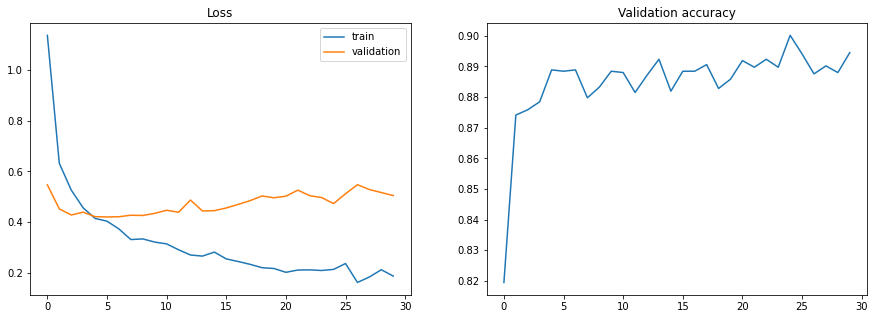

In [48]:
plot_train_process(train_loss, val_loss, val_accuracy)

### BatchNorm try

In [49]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [50]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.390s
	  training loss: 0.608702
	validation loss: 0.429876
	validation accuracy: 0.874
Epoch 2 of 30 took 0.382s
	  training loss: 0.332096
	validation loss: 0.390049
	validation accuracy: 0.887
Epoch 3 of 30 took 0.393s
	  training loss: 0.247035
	validation loss: 0.407847
	validation accuracy: 0.878
Epoch 4 of 30 took 0.389s
	  training loss: 0.185751
	validation loss: 0.423241
	validation accuracy: 0.882
Epoch 5 of 30 took 0.352s
	  training loss: 0.159224
	validation loss: 0.422354
	validation accuracy: 0.896
Epoch 6 of 30 took 0.348s
	  training loss: 0.109476
	validation loss: 0.445447
	validation accuracy: 0.890
Epoch 7 of 30 took 0.368s
	  training loss: 0.081715
	validation loss: 0.438329
	validation accuracy: 0.893
Epoch 8 of 30 took 0.394s
	  training loss: 0.079388
	validation loss: 0.448918
	validation accuracy: 0.897
Epoch 9 of 30 took 0.345s
	  training loss: 0.064069
	validation loss: 0.474082
	validation accuracy: 0.898
Epoch 10 of 30 took 0.374s
	

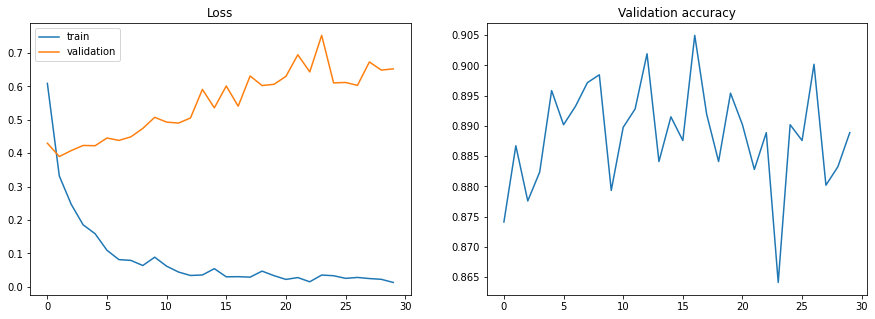

In [51]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [52]:
torch.save(
    model.state_dict(),
    'trained_model.pth'
)

In [53]:
model2 = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10),
) 

print(summary(model2, (784,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
              ReLU-2                  [-1, 300]               0
       BatchNorm1d-3                  [-1, 300]             600
            Linear-4                  [-1, 200]          60,200
              ReLU-5                  [-1, 200]               0
       BatchNorm1d-6                  [-1, 200]             400
            Linear-7                   [-1, 10]           2,010
Total params: 298,710
Trainable params: 298,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------
None


In [59]:
'''
print(torch.allclose(
    model.eval()(example_batch),
    model2(example_batch)
))

print('Load saved model')

model2.load_state_dict(
    torch.load('trained_model.pth')
)
'''

"\nprint(torch.allclose(\n    model.eval()(example_batch),\n    model2(example_batch)\n))\n\nprint('Load saved model')\n\nmodel2.load_state_dict(\n    torch.load('trained_model.pth')\n)\n"

In [55]:
# Note: important to turn loaded model to eval mode
model2.eval()

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=300, out_features=200, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=200, out_features=10, bias=True)
)

In [60]:
'''
print(torch.allclose(
    model(example_batch),
    model2(example_batch), 
    rtol = 1e-3
))
'''

'\nprint(torch.allclose(\n    model(example_batch),\n    model2(example_batch), \n    rtol = 1e-3\n))\n'

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
!ls mnist*.pth

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('<CHECKPOINT NAME>', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)